In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# Table of Contents

* [0. Data collection & Gaining familiarity](#chapter0)
    * [0.1. High level analysis of data](#chapter0_1)
    * [0.2. Comparison of features](#chapter0_2)
* [1. Feature engineering & Initial predictions](#chapter1)
    * [1.1 Feature engineering](#chapter1_1)
    * [1.2 Initial Predictions](#chapter1_2)
* [2. Hyptertuning parameters & Final model selection](#chapter2)
    * [2.1 Initial hypertuning](#chapter2_1)
* [3. Test data prediction & Submission](#chapter3)

## 0. Data collection & Gaining familiarity <a class="anchor" id="chapter0"></a>

In [2]:
# Set the random seed
np.random.seed(42)

In [3]:
# read the data of the training set
spaceship_train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")

### 0.1. High level analysis of data <a class="anchor" id="chapter0_1"></a>

In [4]:
len(spaceship_train)

8693

In [5]:
spaceship_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
spaceship_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


### 0.2. Comparison of features <a class="anchor" id="chapter0_2"></a>

In [7]:
# Make specific metrics as side-by-side tables for easier comparison purposes
# function that takes a column and provides a more detailed dtype value if it is an object
def get_inferred_type(column):
    if pd.api.types.is_object_dtype(column):
        sample_value = column.dropna().iloc[0]
        return type(sample_value).__name__
    else:
        return column.dtype

# Make a function that returns a comparison dataframe
def comparison_table(df):
    return pd.DataFrame({
        'Data Types':df.apply(get_inferred_type),
        'Missing Values':df.isna().sum(),
        'Unique Values':df.nunique()
    })

comparison_train = comparison_table(spaceship_train)
comparison_train

,Data Types,Missing Values,Unique Values
PassengerId,str,0,8693
HomePlanet,str,201,3
CryoSleep,bool,217,2
Cabin,str,199,6560
Destination,str,182,3
Age,float64,179,80
VIP,bool,203,2
RoomService,float64,181,1273
FoodCourt,float64,183,1507
ShoppingMall,float64,208,1115


## 1. Feature engineering & Initial predictions <a class="anchor" id="chapter1"></a>

Based on the data in the previous sections we can discern some items that can go through some feature engineering to provide more data points to compare and see which combination of data creates the highest correlation that can be used to train our models on.

In [8]:
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns

### 1.1 Feature engineering <a class="anchor" id="chapter1_1" ></a>
* `PassengerId`: a sample item looks like `0001_01` which appears like it can be separated by the underscore.
* `Cabin`: a sample item looks like `B/0/P` which looks like it can be separated into 2 string columns and 1 numeric column.
* `Name`: unlike the titanic competition the sample items `Maham Ofracculy` do not appear to provide a title.

Other string based features do not appear to have a large number of unique values, which is the main reason why feature engineering is often times so necessary.

In [9]:
# Make a function to clean the data so that once submission is happening we can \
# be confident that the data is being cleaned the same way as the training data

# This function will be updated as the notebook continues and more cleaning is necessary
def clean_df(df):

    # core cleaning
    # Seperate PassengerId into group and number as float values
    df[['PassId_group','PassId_indiv']] = df['PassengerId'].str.split('_',expand=True).astype('float64')
    df[['cabin_str1','cabin_num','cabin_str2']] = df['Cabin'].str.split('/',expand=True) # Initial split of Cabin cleaning
    df['cabin_num'] = df['cabin_num'].astype('float64') # Convert the cabin number column into a number
    df[['First_name','Last_name']] = df['Name'].str.split(' ',expand=True) # Separate Name into first and last columns

    # return the cleaned dataframe
    return df

# clean the training data
spaceship_clean = clean_df(spaceship_train)

# get the comparison table of the cleaned data
comparison_cleaned = comparison_table(spaceship_clean)
comparison_cleaned

,Data Types,Missing Values,Unique Values
PassengerId,str,0,8693
HomePlanet,str,201,3
CryoSleep,bool,217,2
Cabin,str,199,6560
Destination,str,182,3
Age,float64,179,80
VIP,bool,203,2
RoomService,float64,181,1273
FoodCourt,float64,183,1507
ShoppingMall,float64,208,1115


In [10]:
# Break down all the cleaned features into a dictionary for later comparison analysis
features_clean_orig = {
    'numerical':['PassId_group','PassId_indiv','Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','cabin_num'],
    'categorical':['HomePlanet','Destination','cabin_str1','cabin_str2','First_name','Last_name'],
    'boolean':['CryoSleep','VIP']
}

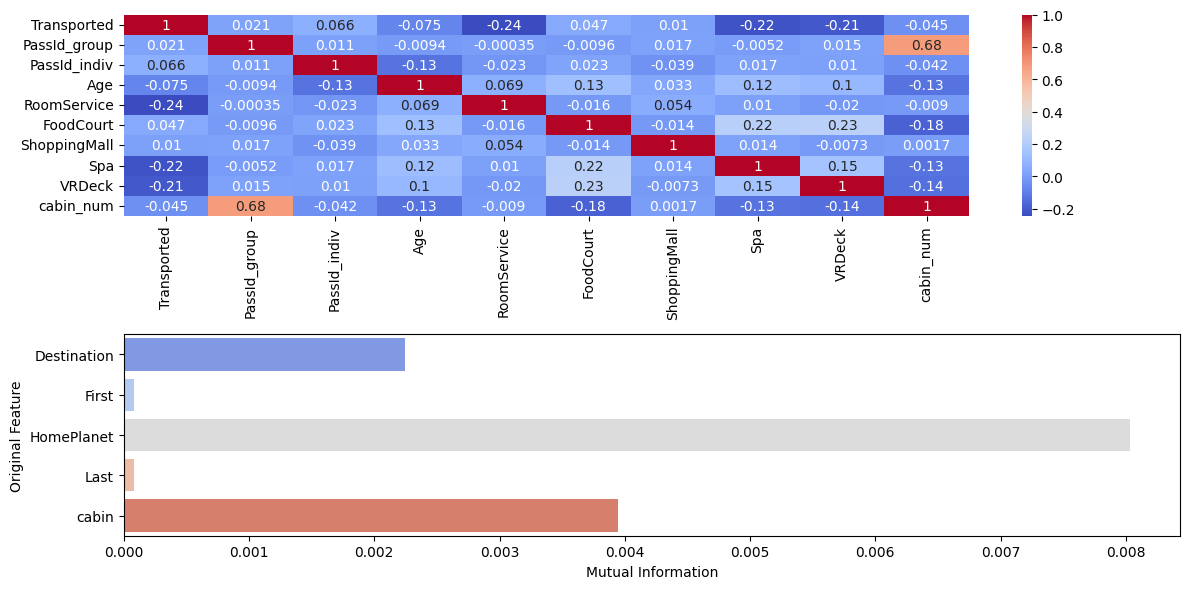

In [11]:
# Make a function to make a heatmap out of the numerical features for future use
def correlate_features(df,features):    
    corr_num_matrix = df[['Transported'] + features['numerical']].corr() # Make a correlation matrix for numerical heatmap
    # Prep the dataframe for categorical heatmap
    encoded_features = pd.get_dummies(df[features['categorical']],drop_first=True)
    mutual_info = mutual_info_classif(encoded_features,df['Transported'],discrete_features=True)
    mi_df = pd.DataFrame({'Features':encoded_features.columns,'Mutual Information':mutual_info})
    mi_df['Original Feature'] = mi_df['Features'].str.split('_').str[0]
    mi_agg_df = mi_df.groupby('Original Feature').agg({'Mutual Information':'mean'}).reset_index()
    # Initiate the subplots
    fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(12,6))
    
    # Plot the heatmap plots
    sns.heatmap(corr_num_matrix,annot=True,cmap='coolwarm',ax=axes[0])
    sns.barplot(data=mi_agg_df,x='Mutual Information',y='Original Feature',palette='coolwarm',ax=axes[1])
    # Create a tight layout to fit everything in
    plt.tight_layout()

# call the numerical heatmap visualization
correlate_features(spaceship_clean,features_clean_orig)

In [12]:
# Because the first and last names appear to be uncorrelated with the \
# classifier column,we can remove them from the categorial set of features.
features_clean_orig['categorical'].remove('First_name')
features_clean_orig['categorical'].remove('Last_name')
features_clean_orig['categorical']

['HomePlanet', 'Destination', 'cabin_str1', 'cabin_str2']

In [13]:
# Test removing some categories again
features_clean_orig['numerical'].remove('ShoppingMall')
features_clean_orig['numerical'].remove('PassId_indiv')
features_clean_orig['numerical']

['PassId_group',
 'Age',
 'RoomService',
 'FoodCourt',
 'Spa',
 'VRDeck',
 'cabin_num']

### 1.2 Initial predictions <a class="anchor" id="chapter1_2" ></a>

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler,OneHotEncoder,FunctionTransformer,PolynomialFeatures
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,r2_score
import itertools

In [15]:
# Make a function to generate a pipeline
def make_pipeline(features,model_object):
    # preprocess the features
    preprocessor = ColumnTransformer(transformers=[
        ('num',Pipeline([
            ('imputer',SimpleImputer(strategy='mean')),
            ('scaler',StandardScaler())
        ]),features['numerical']),
        ('cat',Pipeline([
            ('imputer',SimpleImputer(strategy='most_frequent')),
            ('onehot',OneHotEncoder(drop='first'))
        ]),features['categorical']),
        ('boo',Pipeline([
            ('imputer',SimpleImputer(strategy='most_frequent'))
        ]),features['boolean'])
    ])

    # attach the preprocessor and return the pipeline
    return Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('classifier',model_object)
    ])

In [16]:
# Split the training data into training and validation subsets
X = spaceship_clean.drop('Transported',axis=1)
y = spaceship_clean['Transported']
X_train,X_valid,y_train,y_valid = train_test_split(X,y,stratify=y,random_state=42,test_size=0.2)

In [17]:
# Create a dictionary and a function that will be used to store the results of the scoring in a dictionary for later plotting
model_scoring_dict = {}

def evaluate_preds(true,preds):
    """
    Performs evalution comparisons on y_true values vs. y_pred values on a classification.
    """
    
    # create a dictionary of scoring values
    metric_dict = {
        'accuracy':round(accuracy_score(true,preds),2),
        'precision':round(precision_score(true,preds),2),
        'recall':round(recall_score(true,preds),2),
        'f1':round(f1_score(true,preds),2)
    }
    
    # print the calculated metrics
    for item in metric_dict:
        if item == 'accuracy':
            print(f'{item}: {metric_dict[item]*100:.2f}%')
        else:
            print(f'{item}: {metric_dict[item]:.2f}')
    
    return metric_dict

In [18]:
# Make an initial prediction using RandomForestClassifier
rf1_pipe = make_pipeline(features_clean_orig,RandomForestClassifier(random_state=42))
rf1_pipe.fit(X_train,y_train)
rf1_y_preds = rf1_pipe.predict(X_valid)
model_scoring_dict.update({'RandomForestClassifer baseline':evaluate_preds(y_valid,rf1_y_preds)})

accuracy: 80.00%
precision: 0.83
recall: 0.76
f1: 0.79


## 2. Hypertuning Parameters & Final model selection <a class='anchor' id='chapter2'></a>

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

### 2.1 Initial hypertuning <a class='anchor' id='chapter2_1'></a>

In [20]:
# Set up the parameter grid
param_grid = {
    'classifier__n_estimators':[100,200,300],
    'classifier__max_depth':[10,20,None],
    'classifier__min_samples_split':[2,5,10],
    'classifier__min_samples_leaf':[1,2,4],
    'classifier__bootstrap':[True,False]
}

# Make a scoring dictionary for multiple scorin priorities
multi_scoring = {
    'accuracy':'accuracy',
    'f1':make_scorer(f1_score,average='weighted')
}

# Setting up the GridSearchCV & Fit the model
grid_search_rf1 = GridSearchCV(rf1_pipe,param_grid,cv=5,scoring=multi_scoring,refit='accuracy',n_jobs=-1,verbose=0)
grid_search_rf1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['PassId_group',
                                                                          'Age',
                                                                          'RoomService',
                                                                          'FoodCourt',
                                                                          'Spa',
                                                                          'VRDeck',
                                                                          'cabin_num']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(d...
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__bootstrap': [True, False],
                         'classifier__max_depth': [10, 20, None],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [100, 200, 300]},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'f1': make_scorer(f1_score, average=weighted)})

In [21]:
# Once complete, make a prediction and then add the scoring metrics to th metrics dictionary
grid_search_rf1_y_preds = grid_search_rf1.predict(X_valid)
model_scoring_dict.update({'RandomForestClassifier GridSearchCV':evaluate_preds(y_valid,grid_search_rf1_y_preds)})

accuracy: 81.00%
precision: 0.82
recall: 0.79
f1: 0.80


### 2.2 Alternative model testing & Advanced hypertuning <a class='anchor' id='chapter2_2'></a>

In [22]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RandomizedSearchCV

In [23]:
# Train a baseline model for XGBClassifier and make a prediction
xgb_pipe = make_pipeline(features_clean_orig,XGBClassifier(random_state=42))
xgb_pipe.fit(X_train,y_train)
xgb_y_preds = xgb_pipe.predict(X_valid)

# Add metrics to the scoring dictionary
model_scoring_dict.update({'XGBClassifier baseline':evaluate_preds(y_valid,xgb_y_preds)})

accuracy: 81.00%
precision: 0.82
recall: 0.79
f1: 0.80


In [24]:
# Train a baseline model for CatBoost and make a prediction
cat_pipe = make_pipeline(features_clean_orig,CatBoostClassifier(random_state=42,verbose=0))
cat_pipe.fit(X_train,y_train)
cat_y_preds = cat_pipe.predict(X_valid)

# Add metrics to the scoring dictionary
model_scoring_dict.update({'CatBoost baseline':evaluate_preds(y_valid,cat_y_preds)})

accuracy: 82.00%
precision: 0.82
recall: 0.82
f1: 0.82


In [25]:
# Try making a baseline for stacking classifiers RandomForestClassifier and CatBoostClassifier using LogisticRegression as the final estimator
# Stack the models
rf_cat_model = StackingClassifier(estimators=[
    ('rf',RandomForestClassifier(random_state=42)),
    ('cat',CatBoostClassifier(verbose=0,random_state=42))
],final_estimator=LogisticRegression(),passthrough=True)

# Make a pipeline based on the stacked models, then fit and predict
rf_cat_pipe = make_pipeline(features_clean_orig,rf_cat_model)
rf_cat_pipe.fit(X_train,y_train)
rf_cat_y_preds = rf_cat_pipe.predict(X_valid)

# Add metrics to the scoring dictionary
model_scoring_dict.update({'RandomForest and CatBoost baseline':evaluate_preds(y_valid,rf_cat_y_preds)})

accuracy: 82.00%
precision: 0.82
recall: 0.81
f1: 0.82


<Axes: >

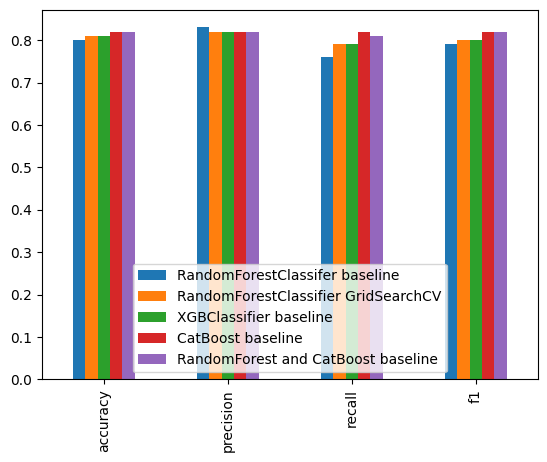

In [26]:
# Once all is said and done, once all the testing is complete plot the metrics for each model for a last comparison
pd.DataFrame(model_scoring_dict).plot.bar()

## 3. Test data prediction & Submission <a class='Anchor' id='chapter3'></a>

In [27]:
# Read the test data
test_data = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

# Clean and process data and make prediciotns on the test data just like how it was done for the training data
Predictions = cat_pipe.predict(clean_df(test_data))

In [28]:
# Build out a dataframe from the predictions that matches the submission criteria
submission = pd.DataFrame({
    'PassengerId':test_data['PassengerId'],
    'Transported':Predictions.flatten()
})

# Output the submission csv to the working folder
submission.to_csv('submission.csv',index=False)